In [1]:
import os
import xarray as xr
import datetime as dt
import numpy as np

mainpath = "/home/jovyan/private/AQ/data/NO2/"
flist = os.listdir(mainpath)

/home/jovyan/.local/lib/python3.8/site-packages/ecmwflibs/__init__.py:131: UserWarning: ecmwflibs universal: found eccodes at /usr/local/lib/libeccodes.so
  warnings.warn(f"ecmwflibs universal: found {name} at {path}")


In [2]:
ds = xr.open_dataset(mainpath + flist[0])
ds

<xarray.Dataset>
Dimensions:           (Latitude: 1350, Longitude: 3590)
Coordinates:
  * Latitude          (Latitude) float32 -59.95 -59.85 -59.75 ... 74.85 74.95
  * Longitude         (Longitude) float32 -179.4 -179.3 -179.2 ... 179.4 179.4
Data variables:
    Tropospheric_NO2  (Latitude, Longitude) float32 ...
    Number_obs        (Latitude, Longitude) float32 ...
Attributes: (12/25)
    history:                        File written on July 05, 2024
    institution:                    George Washington University, Department ...
    source:                         Level 2 NO2 Version 2.4 algorithm from th...
    Conventions:                    CF-1.10
    LongName:                       HAQAST Sentinel-5P TROPOMI Nitrogen Dioxi...
    ShortName:                      HAQ_TROPOMI_NO2_GLOBAL_M_L3
    ...                             ...
    RangeBeginningDate:             2022-11-01
    RangeBeginningTime:             00:00:00.000000Z
    RangeEndingDate:                2022-11-30
    RangeEndingTime:                23:59:59.999999Z
    comment:                        File produced by Dan Goldberg, George Was...
    references:                     Goldberg, D. L., Anenberg, S. C., Kerr, G...

In [13]:
ds.history

'File written on July 05, 2024'

In [39]:
# Now we need to add a time dimension to the data to concatenate
varlist = ['Tropospheric_NO2',
           'Number_obs']
attrlist = ['history',
            'institution',
            'source',
            'LongName',
            'ShortName',
            'VersionID',
            'DataSetQuality',
            'IdentifierProductDOI',
            'GranuleID',
            'comment',
            'references']

day = 15  # These are monthly averages, anchored at the center of the month
years = np.arange(2019, 2024)
for year in years:
    print(year)
    for month in range(1,13):
        fname = str("HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_%02d%4d_V2.4_20240705.nc4" % (month, year))
        ds = xr.open_dataset(mainpath + fname)
        time = [dt.datetime(year, month, day),]
#        ds.expand_dims(dim={"Time": time})
        coords = {'Time': time,
                  'Latitude': ds.Latitude.to_numpy(),
                  'Longitude': ds.Longitude.to_numpy(),}
        dims = ["Time", "Latitude", "Longitude"]
        data_vars = {}
        for key in varlist:
            gdata = ds[key]
            gd = gdata.expand_dims(dim={"Time": time}, axis=0)
            da = xr.DataArray(gd, coords=coords)
            data_vars.update({key: da})
            #for attr in attrlist:
            #    adata = ds[attr]
            #    data_vars.update({attr: adata})

        # Now Dataset
        ds = xr.Dataset(data_vars, coords = coords)
        outfname = fname[:-4] + ".nc"
        ds.to_netcdf(mainpath + "temp/" + outfname)
        ds.close()


2019
2020
2021
2022
2023


<xarray.Dataset>
Dimensions:           (Latitude: 1350, Longitude: 3590)
Coordinates:
  * Latitude          (Latitude) float32 -59.95 -59.85 -59.75 ... 74.85 74.95
  * Longitude         (Longitude) float32 -179.4 -179.3 -179.2 ... 179.4 179.4
Data variables:
    Tropospheric_NO2  (Latitude, Longitude) float32 1.193e+14 5.111e+14 ... nan
    Number_obs        (Latitude, Longitude) float32 3.0 2.0 3.0 ... 0.0 0.0 0.0
Attributes: (12/25)
    history:                        File written on July 05, 2024
    institution:                    George Washington University, Department ...
    source:                         Level 2 NO2 Version 2.4 algorithm from th...
    Conventions:                    CF-1.10
    LongName:                       HAQAST Sentinel-5P TROPOMI Nitrogen Dioxi...
    ShortName:                      HAQ_TROPOMI_NO2_GLOBAL_M_L3
    ...                             ...
    RangeBeginningDate:             2019-12-01
    RangeBeginningTime:             00:00:00.000000Z
    RangeEndingDate:                2019-12-31
    RangeEndingTime:                23:59:59.999999Z
    comment:                        File produced by Dan Goldberg, George Was...
    references:                     Goldberg, D. L., Anenberg, S. C., Kerr, G...

In [13]:
#--- Then put them together into a yearly file---
flist = os.listdir(mainpath + "temp/")
fnames = list()
for f in flist:
    if "2022_V2.4_20240705.nc" in f:
        fnames.append(mainpath + "temp/" + f)#

#print(fnames)
ds = xr.open_mfdataset(fnames)
print(ds)

<xarray.Dataset>
Dimensions:           (Time: 12, Latitude: 1350, Longitude: 3590)
Coordinates:
  * Time              (Time) datetime64[ns] 2022-01-15 2022-02-15 ... 2022-12-15
  * Latitude          (Latitude) float32 -59.95 -59.85 -59.75 ... 74.85 74.95
  * Longitude         (Longitude) float32 -179.4 -179.3 -179.2 ... 179.4 179.4
Data variables:
    Tropospheric_NO2  (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1350, 3590), meta=np.ndarray>
    Number_obs        (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 1350, 3590), meta=np.ndarray>


In [14]:
ds.to_netcdf(mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_202201-202212_V2.4.nc")

In [18]:
files = [mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_201901-201912_V2.4.nc",
        mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_202001-202012_V2.4.nc",
        mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_202101-202112_V2.4.nc",
        mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_202201-202212_V2.4.nc",
        mainpath + "HAQ_TROPOMI_NO2_GLOBAL_QA75_L3_Monthly_202301-202312_V2.4.nc"]
ds = xr.open_mfdataset(files)

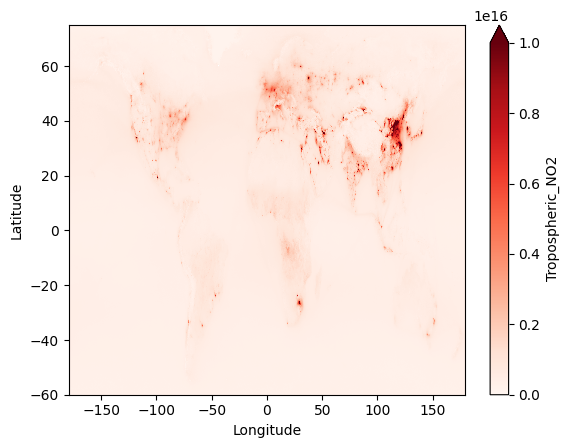

In [23]:
no2_clim = ds.Tropospheric_NO2.mean(dim="Time")
no2_clim.plot(vmin=0, vmax = 1e16, cmap='Reds')